## **Useful TensorFlow Functions**

## **Final Project 4**
#### *CSC 180 Intelligent Systems*
#### *California State University, Sacramento*
---
##### Completed by:
*   Bikram Singh
*   Gloria Nikitchuk
*   Austin Melendez
*   Dhruv Sharma

## **Helper Functions**

In [ ]:
# Written by Dr. Haiquan Chen

%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# One-hot Encoding
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Label Encoding
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## **Data Import**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import cv2
from IPython.display import Image
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
%matplotlib inline

In [ ]:
!pip install opendatasets
import opendatasets as od

if not os.path.exists("./hirise-mars-landmark"):
    od.download(
        "https://www.kaggle.com/datasets/glorianikitchuk/hirise-mars-landmark")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: glorianikitchuk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/glorianikitchuk/hirise-mars-landmark


100%|██████████| 942M/942M [00:17<00:00, 56.9MB/s]


In [ ]:
# Data paths
input_directory = 'hirise-mars-landmark/'
file_name = 'labels-map-proj-v3.txt'
file_path = os.path.join(input_directory, file_name)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path,delimiter=' ',header=None,names=['Image', 'Class'])

df.head()

,Image,Class
0,ESP_011623_2100_RED-0069.jpg,0
1,ESP_011623_2100_RED-0069-r90.jpg,0
2,ESP_011623_2100_RED-0069-r180.jpg,0
3,ESP_011623_2100_RED-0069-r270.jpg,0
4,ESP_011623_2100_RED-0069-fh.jpg,0


In [ ]:
df.shape

(73031, 2)

In [ ]:
landmarks = {
    0: 'other',
    1: 'crater',
    2: 'dark_dune',
    3: 'slope_streak',
    4: 'bright_dune',
    5: 'impact_ejecta',
    6: 'swiss_cheese',
    7: 'spider'
}

class_counts = df['Class'].value_counts().sort_index()
class_counts.index = class_counts.index.map(landmarks)
class_counts

,count
Class,
other,61054
crater,4900
dark_dune,1141
slope_streak,2331
bright_dune,1750
impact_ejecta,231
swiss_cheese,1148
spider,476


## **Data Preprocessing**

In [ ]:
# decreasing the amount of images of type class 'other'  (keeping 5000)
df_reduced = pd.concat([df[df['Class'] == 0].sample(n=5000, random_state=42), df[df['Class'] != 0]])

class_counts = df_reduced['Class'].value_counts().sort_index()
class_counts.index = class_counts.index.map(landmarks)
class_counts

,count
Class,
other,5000
crater,4900
dark_dune,1141
slope_streak,2331
bright_dune,1750
impact_ejecta,231
swiss_cheese,1148
spider,476


In [ ]:
# removed images of spider and impact_ejecta class
df_reduced = df_reduced[~df_reduced['Class'].isin([5, 7])]
df_reduced['Class'] = df_reduced['Class'].apply(lambda x: x - 1 if x > 5 else x)

class_counts = df_reduced['Class'].value_counts().sort_index()
class_counts.index = class_counts.index.map(landmarks)
class_counts

,count
Class,
other,5000
crater,4900
dark_dune,1141
slope_streak,2331
bright_dune,1750
impact_ejecta,1148


In [ ]:
df_reduced['Class'].unique()

array([0, 1, 3, 2, 5, 4])

In [ ]:
df_reduced.head()

,Image,Class
44603,PSP_010087_1555_RED-0057-brt.jpg,0
12505,ESP_023382_1845_RED-0098-r270.jpg,0
3998,ESP_029782_2075_RED-0116-r90.jpg,0
25181,ESP_018416_2060_RED-0039-r180.jpg,0
17646,ESP_034737_2090_RED-0187-brt.jpg,0


In [ ]:
image_directory = 'hirise-mars-landmark/map-proj-v3/map-proj-v3/'
images_output = []

# Written by Dr. Haiquan Chen, adapted by Gloria Nikitchuk
for row_index, row in df_reduced.iterrows():

    full_image_path = os.path.join(image_directory, row.Image)
    image_temp = cv2.imread(full_image_path)
    image = cv2.resize(image_temp, (128, 128))

    images_output.append(image)


In [ ]:
# Create a copy of the 'Class' column (output feature)
y = df_reduced['Class']

# Drop Image column
df_reduced.drop('Image', axis=1, inplace=True)

# One hot encoding
encode_text_dummy(df_reduced,'Class')
df_reduced.head()

,Class-0,Class-1,Class-2,Class-3,Class-4,Class-5
44603,True,False,False,False,False,False
12505,True,False,False,False,False,False
3998,True,False,False,False,False,False
25181,True,False,False,False,False,False
17646,True,False,False,False,False,False


In [ ]:
# Create numpy array of images and classes
x_images = np.asarray(images_output)
x_classes = df_reduced.values

In [ ]:
print(x_images.shape)
print(x_classes.shape)

(16270, 128, 128, 3)
(16270, 6)


In [ ]:
x_images

array([[[[ 62,  62,  62],
         [ 63,  63,  63],
         [ 63,  63,  63],
         ...,
         [ 79,  79,  79],
         [ 78,  78,  78],
         [ 77,  77,  77]],

        [[ 63,  63,  63],
         [ 65,  65,  65],
         [ 66,  66,  66],
         ...,
         [ 79,  79,  79],
         [ 77,  77,  77],
         [ 76,  76,  76]],

        [[ 67,  67,  67],
         [ 69,  69,  69],
         [ 71,  71,  71],
         ...,
         [ 78,  78,  78],
         [ 77,  77,  77],
         [ 76,  76,  76]],

        ...,

        [[ 58,  58,  58],
         [ 59,  59,  59],
         [ 59,  59,  59],
         ...,
         [110, 110, 110],
         [108, 108, 108],
         [106, 106, 106]],

        [[ 57,  57,  57],
         [ 58,  58,  58],
         [ 59,  59,  59],
         ...,
         [115, 115, 115],
         [112, 112, 112],
         [108, 108, 108]],

        [[ 57,  57,  57],
         [ 57,  57,  57],
         [ 58,  58,  58],
         ...,
         [119, 119, 119],
        

In [ ]:
x_classes

array([[ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       ...,
       [False, False,  True, False, False, False],
       [False, False,  True, False, False, False],
       [False, False,  True, False, False, False]])

In [ ]:
# Split image data into Train/Test
x_images_train, x_images_test, x_class_train, x_class_test, y_train, y_test = train_test_split(x_images, x_classes, y, test_size=0.25, random_state=42)

In [ ]:
print("x_images_train shape: ", x_images_train.shape)
print("x_images_test shape: ", x_images_test.shape)
print("x_class_train shape: ", x_class_train.shape)
print("x_class_test shape: ", x_class_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_images_train shape:  (12202, 128, 128, 3)
x_images_test shape:  (4068, 128, 128, 3)
x_class_train shape:  (12202, 6)
x_class_test shape:  (4068, 6)
y_train shape:  (12202,)
y_test shape:  (4068,)


## **CNN Model**

In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_CLASSES = len(df_reduced.columns)

# Input Layer
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [ ]:
# First Convolutional Block
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

# Second Convolutional Block
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

# Third Convolutional Block
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

# Fourth Convolutional Block
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
dropout1 = Dropout(0.4)(pool4)

# Flatten the feature maps
flatten = Flatten()(dropout1)

# Fully Connected Layers
dense1 = Dense(512, activation='relu')(flatten)
dropout2 = Dropout(0.5)(dense1)

dense2 = Dense(256, activation='relu')(dropout2)
dropout3 = Dropout(0.4)(dense2)

# Output Layer
output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout3)

# Creating the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer and a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

In [ ]:
# Callbacks to avoid overfitting and improve training performance
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Training the Model
history = model.fit(
    x_images_train, x_class_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_images_test, x_class_test),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

In [ ]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


In [ ]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_images_test, x_class_test, verbose=0)  # Note that x_class_test is the one-hot encoded version
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make Predictions on Test Data
y_pred_prob = model.predict(x_images_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(x_class_test, axis=1)  # Convert one-hot encoded labels to original labels

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate and print the classification report for a detailed evaluation
print("\nClassification Report:")
class_names = ['other', 'crater', 'dark dune', 'slope streak', 'bright dune', 'swiss cheese']  # Adjusted as per reduced classes
print(classification_report(y_test_labels, y_pred, target_names=class_names))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cnn_conf_matrix = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Convert the labels to one-hot encoding for ROC curve calculation
y_test_bin = label_binarize(y_test_labels, classes=list(range(NUM_CLASSES)))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for all classes with updated labels
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plotting the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## **VGG16 Transfer Learning Model**


In [ ]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

vgg16_model = Sequential()

for layer in vgg_model.layers:
    vgg16_model.add(layer)

for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# Add layers for classification task
vgg16_model.add(Flatten())

vgg16_model.add(Dense(6, activation='softmax'))

vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

vgg16_model.fit(x_images_train, x_class_train,
                batch_size=128,
                epochs=50,
                verbose=2,
                callbacks=[early_stop],
                validation_data=(x_images_test, x_class_test))

Epoch 1/50
96/96 - 25s - 257ms/step - accuracy: 0.8145 - loss: 1.6335 - val_accuracy: 0.8744 - val_loss: 0.8448
Epoch 2/50
96/96 - 38s - 395ms/step - accuracy: 0.9153 - loss: 0.4587 - val_accuracy: 0.8835 - val_loss: 0.8049
Epoch 3/50
96/96 - 46s - 480ms/step - accuracy: 0.9425 - loss: 0.2591 - val_accuracy: 0.8820 - val_loss: 0.8129
Epoch 4/50
96/96 - 36s - 377ms/step - accuracy: 0.9548 - loss: 0.1751 - val_accuracy: 0.8968 - val_loss: 0.8046
Epoch 5/50
96/96 - 45s - 474ms/step - accuracy: 0.9672 - loss: 0.1106 - val_accuracy: 0.9012 - val_loss: 0.7724
Epoch 6/50
96/96 - 41s - 428ms/step - accuracy: 0.9762 - loss: 0.0714 - val_accuracy: 0.9012 - val_loss: 0.7482
Epoch 7/50
96/96 - 36s - 376ms/step - accuracy: 0.9823 - loss: 0.0550 - val_accuracy: 0.9034 - val_loss: 0.7710
Epoch 8/50
96/96 - 41s - 427ms/step - accuracy: 0.9874 - loss: 0.0357 - val_accuracy: 0.9019 - val_loss: 0.7481
Epoch 9/50
96/96 - 41s - 426ms/step - accuracy: 0.9901 - loss: 0.0301 - val_accuracy: 0.9068 - val_loss:

In [ ]:
vgg16_model.summary()

In [ ]:
# Evaluate the model
vgg_pred_prob = vgg16_model.predict(x_images_test)
vgg_pred = np.argmax(vgg_pred_prob, axis=1)

# Calculate precision, recall, and F1-score
vgg_precision = metrics.precision_score(y_test, vgg_pred, average='weighted')
vgg_recall = metrics.recall_score(y_test, vgg_pred, average='weighted')
vgg_f1 = metrics.f1_score(y_test, vgg_pred, average='weighted')

128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f'VGG16 Precision Score: {vgg_precision}')
print(f'VGG16 Recall Score: {vgg_recall}')
print(f'VGG16 F1 Score: {vgg_f1}')

VGG16 Precision Score: 0.8350143663436879
VGG16 Recall Score: 0.8338249754178958
VGG16 F1 Score: 0.8342085508452738


In [ ]:
print(vgg_pred_prob)

[[9.9983120e-01 1.6878273e-04 3.0958140e-09 2.6346798e-09 1.7458898e-17
  5.8331710e-14]
 [3.1977631e-42 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.4461400e-42]
 [2.7016955e-26 1.0000000e+00 6.3242514e-21 1.1083935e-39 4.1558281e-36
  6.6149791e-28]
 ...
 [1.0213045e-21 9.0769831e-30 1.6889305e-19 1.2611686e-44 1.6267028e-26
  1.0000000e+00]
 [1.7080528e-07 9.9998569e-01 2.6146503e-07 7.9233996e-17 1.3989077e-05
  1.4324873e-11]
 [1.0000000e+00 7.2144884e-19 1.9153353e-19 8.1509756e-21 1.0705818e-24
  6.7275754e-24]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


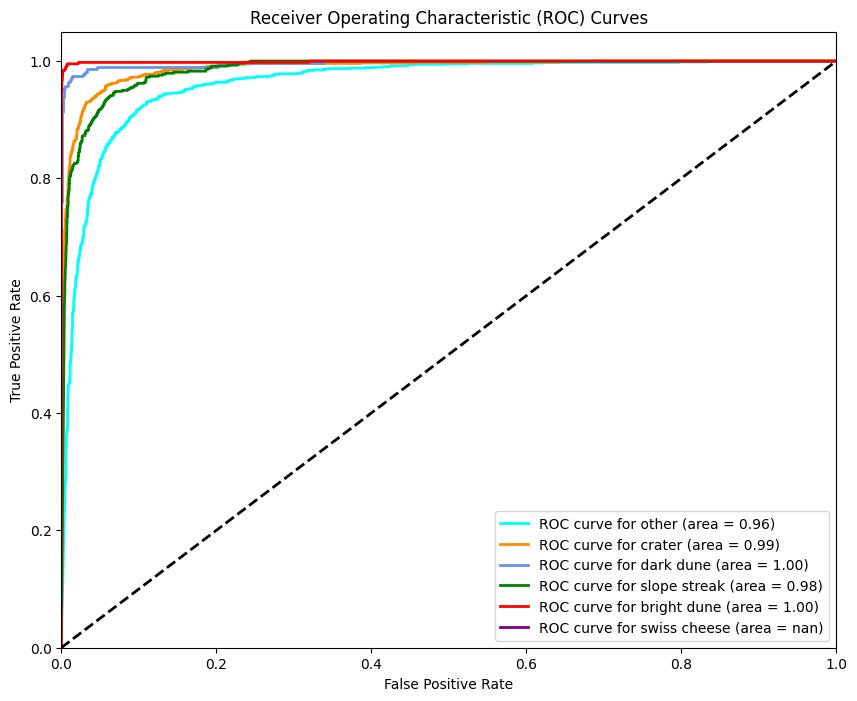

In [ ]:
NUM_CLASSES = 6

# Plot ROC curves
# Convert the labels to one-hot encoding for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=list(range(NUM_CLASSES)))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], vgg_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for all classes with updated labels
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plotting the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

vgg_conf_matrix = confusion_matrix(y_test, vgg_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=vgg_conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## **Vision Transformer (ViT)**

In [ ]:
# Import transformer libraries
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTImageProcessor
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.optim as optim
import torch.nn as nn
from PIL import Image

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Custom Dataset class for Mars images
class MarsImageDataset(Dataset):
    def __init__(self, images, labels, feature_extractor):
        self.images = images
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert numpy image to PIL
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]

        # Apply feature extractor
        inputs = self.feature_extractor(image, return_tensors="pt")
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(0)  # Remove batch dimension
        return inputs['pixel_values'], torch.tensor(label)

In [ ]:
# Initialize feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Remap Class Labels from 0 - 5
new_landmarks = {
    0: 'other',
    1: 'crater',
    2: 'dark_dune',
    3: 'slope_streak',
    4: 'bright_dune',
    6: 'swiss_cheese'
}

remap_dict = {
    0: 0,  # other -> 0
    1: 1,  # crater -> 1
    2: 2,  # dark_dune -> 2
    3: 3,  # slope_streak -> 3
    4: 4,  # bright_dune -> 4
    5: 5   # swiss_cheese -> 5
}

y_train = np.array([remap_dict[label] for label in y_train])
y_test = np.array([remap_dict[label] for label in y_test])

final_landmarks = {
    0: 'other',
    1: 'crater',
    2: 'dark_dune',
    3: 'slope_streak',
    4: 'bright_dune',
    5: 'swiss_cheese'  # Now 6 becomes 5
}

print("Unique values in training set:", np.unique(y_train))
print("Unique values in test set:", np.unique(y_test))



Unique values in training set: [0 1 2 3 4 5]
Unique values in test set: [0 1 2 3 4 5]


In [ ]:
train_class_counts = pd.Series(y_train).value_counts().sort_index()
train_class_counts.index = train_class_counts.index.map(final_landmarks)
print("\nTraining class distribution after remapping:")
print(train_class_counts)


Training class distribution after remapping:
other           3753
crater          3659
dark_dune        863
slope_streak    1751
bright_dune     1323
swiss_cheese     853
Name: count, dtype: int64


In [ ]:
# Balance Classes
indices = np.arange(len(y_train))

# Get indices for each class
other_indices = indices[y_train == 0]  # 'other' class
crater_indices = indices[y_train == 1]  # 'crater' class
remaining_indices = indices[~np.isin(y_train, [0, 1])]  # all other classes

# Randomly select 2000 samples from 'other' and 'crater' classes
np.random.seed(42)  # for reproducibility
other_selected = np.random.choice(other_indices, size=2000, replace=False)
crater_selected = np.random.choice(crater_indices, size=2000, replace=False)

# Combine all indices
final_indices = np.concatenate([other_selected, crater_selected, remaining_indices])

# Create new reduced datasets
x_images_train_balanced = x_images_train[final_indices]
y_train_balanced = y_train[final_indices]

# Verify new class distribution
train_class_counts = pd.Series(y_train_balanced).value_counts().sort_index()
train_class_counts.index = train_class_counts.index.map(final_landmarks)
print("\nNew training class distribution:")
print(train_class_counts)

# Create new dataset with balanced data
full_dataset = MarsImageDataset(x_images_train_balanced, y_train_balanced, feature_extractor)


New training class distribution:
other           2000
crater          2000
dark_dune        863
slope_streak    1751
bright_dune     1323
swiss_cheese     853
Name: count, dtype: int64


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            if self.verbose:
                print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), self.path)
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
y_train

array([1, 0, 1, ..., 0, 1, 4])

In [ ]:
# Initialize feature extractor
# feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Split training data into train and validation
train_size = int(len(x_images_train) * 0.8)
indices = np.arange(len(x_images_train))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create datasets
full_dataset = MarsImageDataset(x_images_train, y_train, feature_extractor)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = MarsImageDataset(x_images_test, y_test, feature_extractor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
len(np.unique(y_train))

6

In [ ]:
# Initialize model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(np.unique(y_train)),
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
def train_mars_classifier(batch_size=32, num_epochs=10, learning_rate=5e-5, patience=3):

    # Setup training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(pixel_values=images)
                loss = criterion(outputs.logits, labels)

                val_loss += loss.item()
                _, predicted = outputs.logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_model.pth'))

    # Test phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)

            test_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total

    print('\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return model

In [ ]:
model = train_mars_classifier()

Epoch [1/10]
Train Loss: 0.2066, Train Acc: 93.07%
Val Loss: 0.0898, Val Acc: 97.30%
------------------------------------------------------------
Validation loss decreased (inf --> 0.089795). Saving model...
Epoch [2/10]
Train Loss: 0.0501, Train Acc: 98.42%
Val Loss: 0.0994, Val Acc: 96.80%
------------------------------------------------------------
EarlyStopping counter: 1 out of 3
Epoch [3/10]
Train Loss: 0.0232, Train Acc: 99.20%
Val Loss: 0.0989, Val Acc: 96.85%
------------------------------------------------------------
EarlyStopping counter: 2 out of 3
Epoch [4/10]
Train Loss: 0.0203, Train Acc: 99.36%
Val Loss: 0.1117, Val Acc: 96.76%
------------------------------------------------------------
EarlyStopping counter: 3 out of 3
Early stopping triggered at epoch 4


<ipython-input-31-3790fe5f5b9f>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Results:
Test Loss: 0.0919, Test Acc: 97.07%


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
  for batch in test_loader:
    pixel_values, labels = batch
    input_ids = pixel_values.to(device)
    labels = labels.to(device)

    # Get model predictions
    outputs = model(input_ids)
    predictions = torch.argmax(outputs.logits, dim=1)
    probabilities = torch.softmax(outputs.logits, dim=1)

    # Store probabilities for ROC curve
    all_probabilities.extend(probabilities.cpu().numpy())

    # Move predictions and labels to CPU and convert to NumPy arrays
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert list to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)


Overall Metrics:
Accuracy: 0.9707

Weighted-averaged Metrics:
Weighted F1 Score: 0.9707
Weighted Recall: 0.9707
Weighted Precision: 0.9708

Detailed Classification Report:
              precision    recall  f1-score   support

       other     0.9512    0.9543    0.9528      1247
      crater     0.9711    0.9742    0.9726      1241
   dark_dune     0.9789    1.0000    0.9893       278
slope_streak     0.9822    0.9534    0.9676       580
 bright_dune     1.0000    0.9953    0.9977       427
swiss_cheese     0.9800    0.9966    0.9882       295

    accuracy                         0.9707      4068
   macro avg     0.9772    0.9790    0.9780      4068
weighted avg     0.9708    0.9707    0.9707      4068



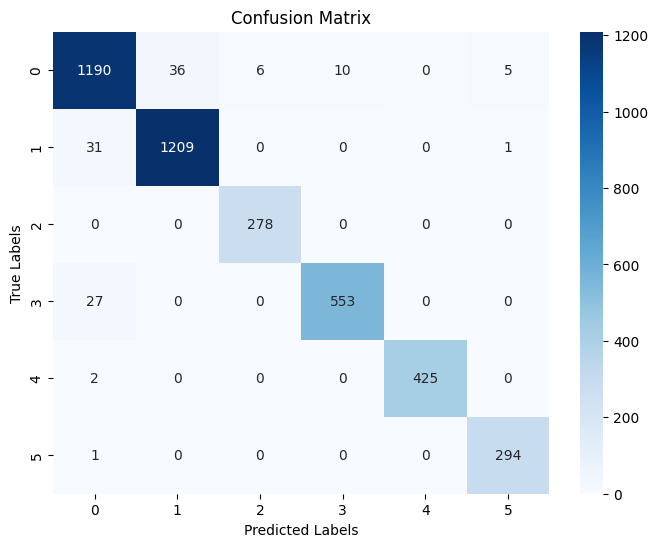

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report
# Compute all metrics
accuracy = accuracy_score(all_labels, all_predictions)

# Weighted averaging
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')

# Per-class metrics
class_names = list(final_landmarks.values())
report = classification_report(all_labels, all_predictions,
                              target_names=class_names,
                              digits=4)

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("\nWeighted-averaged Metrics:")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print("\nDetailed Classification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(all_labels))), yticklabels=np.arange(len(np.unique(all_labels))))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
def plot_roc_curves(labels: np.ndarray, probabilities: np.ndarray, num_classes: int):
    """
    Calculate and plot ROC curves for multi-class classification.

    Args:
        labels: True labels
        probabilities: Predicted probabilities for each class
        num_classes: Number of classes

    Returns:
        dict: Dictionary containing FPR, TPR, and AUC for each class
    """
    # Binarize labels for multi-class ROC
    labels_bin = label_binarize(labels, classes=range(num_classes))

    # Initialize dictionaries to store ROC data
    roc_data = {
        'fpr': {},
        'tpr': {},
        'auc': {}
    }

    plt.figure(figsize=(10, 8))

    # Calculate ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Store ROC data
        roc_data['fpr'][i] = fpr
        roc_data['tpr'][i] = tpr
        roc_data['auc'][i] = roc_auc

        # Plot ROC curves
        plt.plot(
            fpr,
            tpr,
            label=f'ROC curve (class {i}) (AUC = {roc_auc:0.2f})'
        )

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")

    plt.close()

    return roc_data

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
def plot_roc_curves2(labels: np.ndarray, probabilities: np.ndarray, num_classes: int,
                   class_names: list = None, save_path: str = 'roc_curves.png'):
    """
    Calculate and plot ROC curves for multi-class classification.

    Args:
        labels: True labels
        probabilities: Predicted probabilities for each class
        num_classes: Number of classes
        class_names: Optional list of class names for each class
        save_path: Path to save the plot

    Returns:
        dict: Dictionary containing FPR, TPR, and AUC for each class
    """
    # Set style
    #plt.style.use('seaborn')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create color palette
    colors = sns.color_palette('husl', n_colors=num_classes)

    # Binarize labels for multi-class ROC
    labels_bin = label_binarize(labels, classes=range(num_classes))

    # Initialize dictionaries to store ROC data
    roc_data = {
        'fpr': {},
        'tpr': {},
        'auc': {}
    }

    # Calculate ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)

        # Store ROC data
        roc_data['fpr'][i] = fpr
        roc_data['tpr'][i] = tpr
        roc_data['auc'][i] = roc_auc

        # Get class name
        class_label = class_names[i] if class_names else f'Class {i}'

        # Plot ROC curves with custom colors
        plt.plot(
            fpr,
            tpr,
            color=colors[i],
            lw=2,
            label=f'{class_label} (AUC = {roc_auc:.3f})'
        )

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random chance')

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, pad=20)

    # Customize legend
    plt.legend(loc="lower right", fontsize=10, bbox_to_anchor=(1.15, 0))

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Print AUC scores
    print("\nAUC Scores:")
    for i in range(num_classes):
        class_label = class_names[i] if class_names else f'Class {i}'
        print(f"{class_label}: {roc_data['auc'][i]:.3f}")

    # Calculate and print micro-average AUC
    micro_auc = sum(roc_data['auc'].values()) / num_classes
    print(f"\nMicro-average AUC: {micro_auc:.3f}")

    return roc_data


AUC Scores:
other: 0.994
crater: 0.998
dark_dune: 1.000
slope_streak: 0.999
bright_dune: 1.000
swiss_cheese: 1.000

Micro-average AUC: 0.998


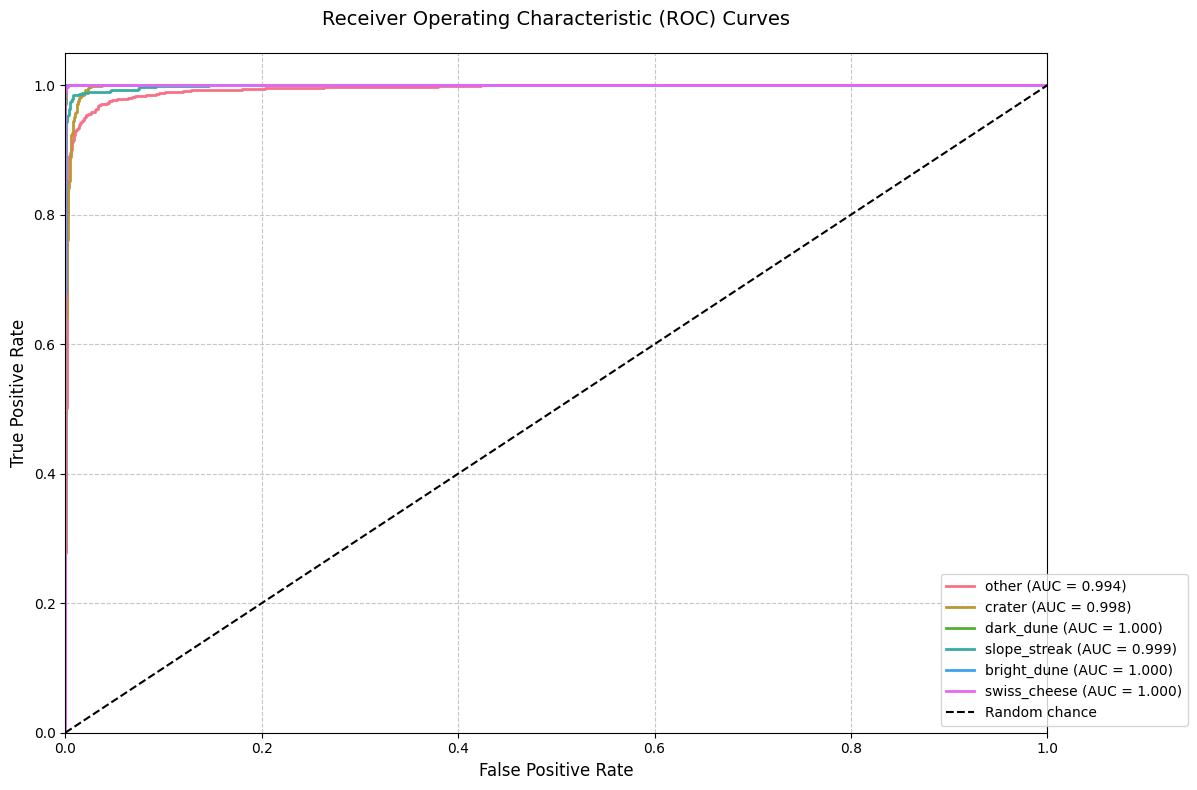

In [ ]:
class_names = ["other", "crater", "dark_dune", "slope_streak", "bright_dune", "swiss_cheese"]
roc_data = plot_roc_curves2(
    all_labels,
    all_probabilities,
    num_classes=6,
    class_names=class_names,
    save_path='transformer_roc_curves.png'
)